In [1]:
%load_ext pycodestyle_magic
%load_ext jupyternotify
%load_ext autoreload
%autoreload 2
%matplotlib inline

<IPython.core.display.Javascript object>

In [2]:
import sys
sys.path.append('../')

In [160]:
from utils.data import CIFAR10_dataset
from utils.misc import (
    show_random_images,
    get_device,
    set_seed,
    is_cuda,
    show_model_summary,
    show_img_grid,
    show_random_images_for_each_class,
)
from utils.model import Net
from utils.training import train
from utils.testing import test

In [4]:
set_seed()
cuda = is_cuda()
device = get_device()

[INFO] seed set 1
[INFO] Cuda Avaliable :  False
[INFO] device :  cpu


In [505]:
train_loader = CIFAR10_dataset(
    train=True, cuda=cuda
).get_loader()
test_loader = CIFAR10_dataset(
    train=False, cuda=cuda
).get_loader()

Files already downloaded and verified

        [INFO] train dataset of size 50000 loaded...
        
Files already downloaded and verified

        [INFO] test dataset of size 10000 loaded...
        


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


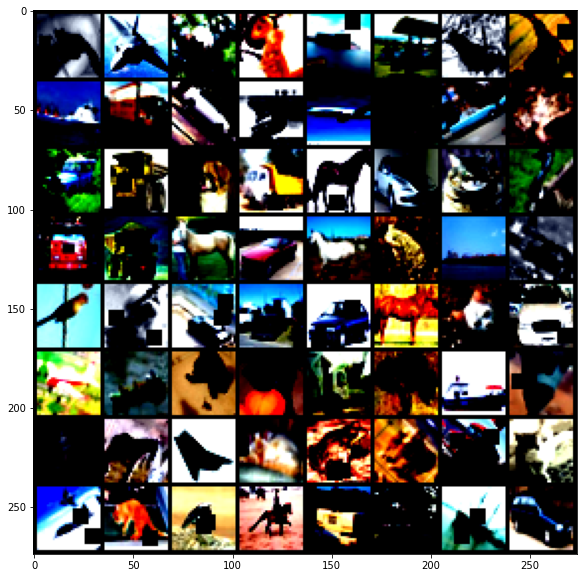

In [509]:
show_random_images(train_loader)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


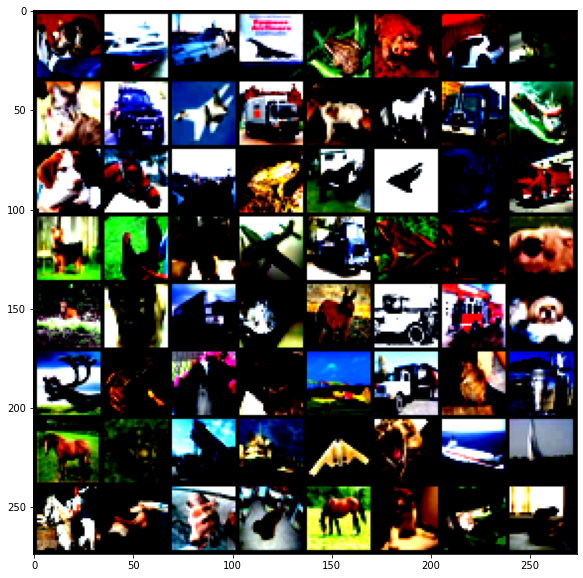

In [507]:
show_random_images(test_loader)

## Calculate mean and std of dataset

In [163]:
train_data = CIFAR10_dataset(
    train=True, cuda=cuda, normalized=False
).get_data()
test_data = CIFAR10_dataset(
    train=False, cuda=cuda, normalized=False
).get_data()

Files already downloaded and verified
Files already downloaded and verified


In [84]:
## mean of data
[
    round(train_data.data[..., n].mean() / 255, 3)
    for n in range(train_data.data.shape[-1])
]

[0.491, 0.482, 0.447]

In [85]:
## mean of data
[
    round(train_data.data[..., n].std() / 255, 3)
    for n in range(train_data.data.shape[-1])
]

[0.247, 0.243, 0.262]

## look at data

In [143]:
from collections import Counter
import matplotlib.pyplot as plt
import random
import numpy as np
import torchvision
import torch

In [87]:
train_data.data.shape

(50000, 32, 32, 3)

In [92]:
len(train_data.targets)

50000

In [165]:
## 1000 images per class for test, and 5000 images per class for train

<BarContainer object of 10 artists>

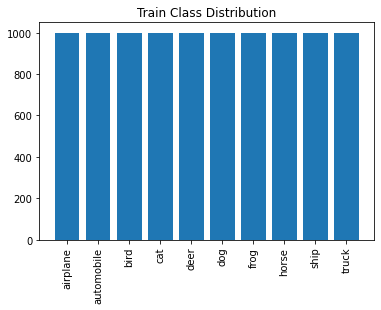

In [164]:
plt.xticks(rotation='vertical')
plt.title("Train Class Distribution")
plt.bar(train_data.classes, Counter(train_data.targets).values())

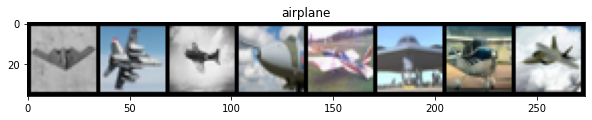

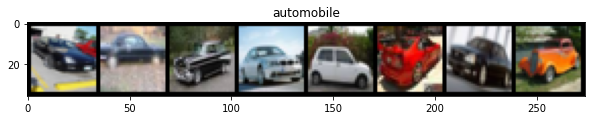

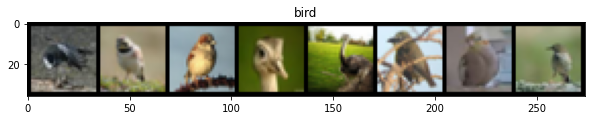

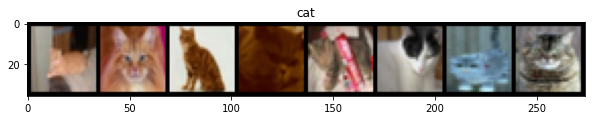

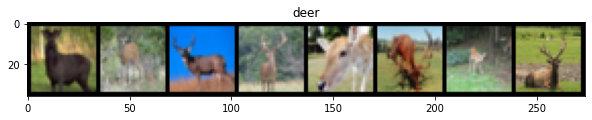

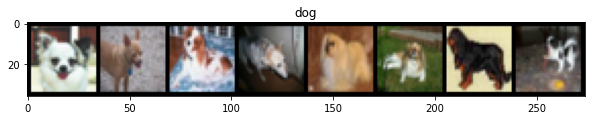

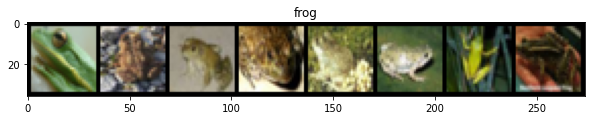

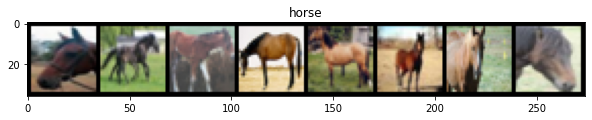

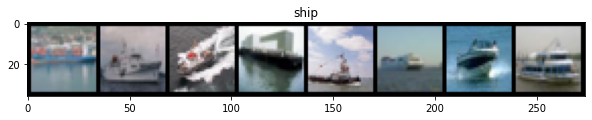

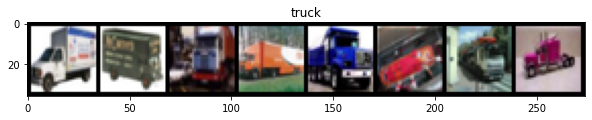

In [162]:
show_random_images_for_each_class(train_data, num_images_per_class=8)

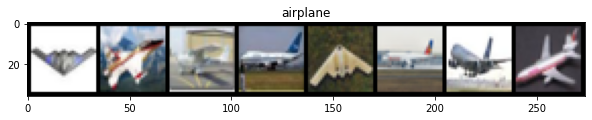

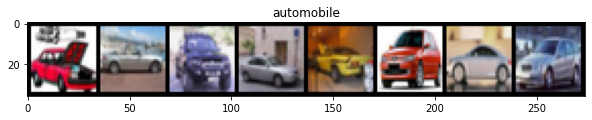

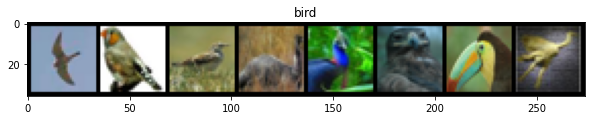

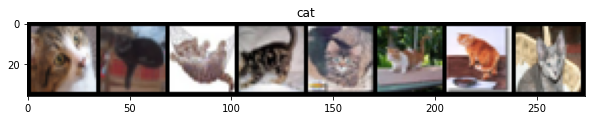

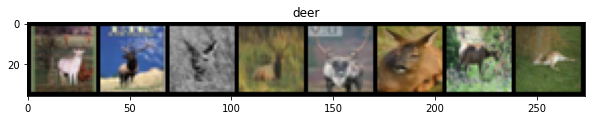

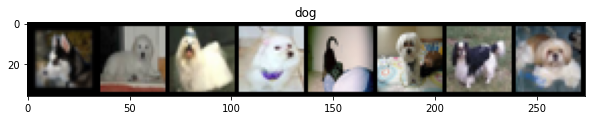

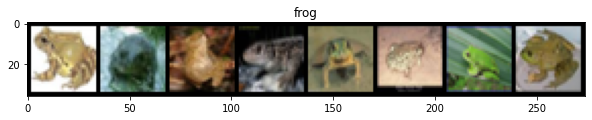

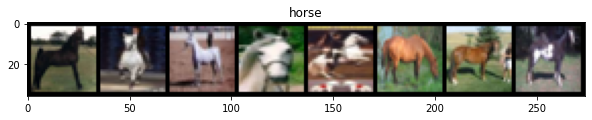

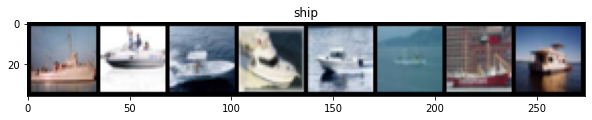

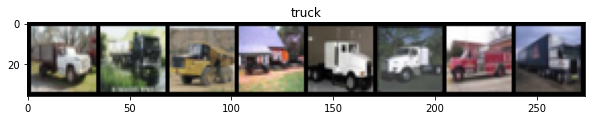

In [168]:
show_random_images_for_each_class(test_data, num_images_per_class=8)

In [427]:
class SeparableConv2d(torch.nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=1,stride=1,padding=0,dilation=1,bias=False):
        super(SeparableConv2d,self).__init__()

        self.conv1 = torch.nn.Conv2d(in_channels,in_channels,kernel_size,stride,padding,dilation,groups=in_channels,bias=bias)
        self.pointwise = torch.nn.Conv2d(in_channels,out_channels,1,1,0,1,1,bias=bias)
    
    def forward(self,x):
        x = self.conv1(x)
        x = self.pointwise(x)
        return x

In [428]:
conv_op = lambda i, o, k, p: torch.nn.Conv2d(i, o, k, padding=p, bias = False)
stride_conv = lambda i, o, k, p: torch.nn.Conv2d(i, o, k, stride=2, padding=p)
dilated_conv = lambda i, o, k, p: torch.nn.Conv2d(i, o, k, stride=2, padding=p, dilation=2)

sep_conv = lambda i, o, k, p: SeparableConv2d(i, o, kernel_size=k, padding=p)
pool = torch.nn.MaxPool2d(2, 2)
ap = torch.nn.AvgPool2d(6)

In [429]:
x = torch.randn(10, 3, 32, 32)
i = x.shape[1]
x.shape

torch.Size([10, 3, 32, 32])

In [430]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = dilated_conv(i, 32, 1, 1)(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 32, 32]) 32
torch.Size([10, 64, 32, 32]) 64
torch.Size([10, 32, 17, 17]) 32


In [431]:
x = sep_conv(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = sep_conv(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = stride_conv(i, 32, 1, 0)(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 17, 17]) 32
torch.Size([10, 64, 17, 17]) 64
torch.Size([10, 32, 9, 9]) 32


In [395]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = stride_conv(i, 32, 1, 0)(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 17, 17]) 32
torch.Size([10, 64, 17, 17]) 64
torch.Size([10, 32, 9, 9]) 32


In [396]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = stride_conv(i, 32, 1, 1)(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 9, 9]) 32
torch.Size([10, 64, 9, 9]) 64
torch.Size([10, 32, 6, 6]) 32


In [397]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 6, 6]) 32
torch.Size([10, 64, 6, 6]) 64


In [282]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 32, 1, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = pool(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 32, 32]) 32
torch.Size([10, 64, 32, 32]) 64
torch.Size([10, 32, 34, 34]) 32
torch.Size([10, 32, 17, 17]) 32


In [283]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 32, 1, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = pool(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 17, 17]) 32
torch.Size([10, 64, 17, 17]) 64
torch.Size([10, 32, 19, 19]) 32
torch.Size([10, 32, 9, 9]) 32


In [284]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 32, 1, 0)(x)
i = x.shape[1]
print(x.shape, i)

x = pool(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 9, 9]) 32
torch.Size([10, 64, 9, 9]) 64
torch.Size([10, 32, 9, 9]) 32
torch.Size([10, 32, 4, 4]) 32


In [285]:
x = conv_op(i, 32, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 64, 3, 1)(x)
i = x.shape[1]
print(x.shape, i)

x = conv_op(i, 10, 1, 1)(x)
i = x.shape[1]
print(x.shape, i)

torch.Size([10, 32, 4, 4]) 32
torch.Size([10, 64, 4, 4]) 64
torch.Size([10, 10, 6, 6]) 10


In [288]:
ap(x).shape

torch.Size([10, 10, 1, 1])

In [ ]:
conv = torch.nn.Conv2d(32, 64, 1, padding=1, bias = False)

In [204]:
conv = torch.nn.Conv2d(32, 64, 1, padding=1, bias = False)

In [208]:
torch.randn(10, 16, 16, 32).shape

torch.Size([10, 16, 16, 32])

In [210]:
conv(torch.randn(10, 32, 16, 16)).shape

torch.Size([10, 64, 18, 18])

In [198]:
ap = torch.nn.AdaptiveAvgPool2d(1)

In [201]:
input = torch.randn(20, 10, 6, 6)

In [202]:
ap(input).shape

torch.Size([20, 10, 1, 1])

In [446]:
net = Net(dropout_value=0.1, BN=True).to(device)

In [447]:
show_model_summary(net, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
           Dropout-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 64, 32, 32]          18,432
              ReLU-6           [-1, 64, 32, 32]               0
           Dropout-7           [-1, 64, 32, 32]               0
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 32, 17, 17]           2,080
             ReLU-10           [-1, 32, 17, 17]               0
           Conv2d-11           [-1, 64, 17, 17]          18,432
             ReLU-12           [-1, 64, 17, 17]               0
          Dropout-13           [-1, 64, 17, 17]               0
      BatchNorm2d-14           [-1, 64,

## albumenation

In [448]:
! pip install -U albumentations

     |████████████████████████████████| 98 kB 3.0 MB/s eta 0:00:01
  Using cached scikit_image-0.18.1-cp38-cp38-macosx_10_9_x86_64.whl (12.7 MB)
     |████████████████████████████████| 43.7 MB 3.9 MB/s eta 0:00:01    |██▊                             | 3.7 MB 3.7 MB/s eta 0:00:11
  Using cached networkx-2.5.1-py3-none-any.whl (1.6 MB)
  Using cached imageio-2.9.0-py3-none-any.whl (3.3 MB)
  Using cached PyWavelets-1.1.1-cp38-cp38-macosx_10_9_x86_64.whl (4.3 MB)


In [484]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(
       shift_limit=0.0625, scale_limit=0.1, 
        rotate_limit=45, interpolation=1, 
        border_mode=4, p=0.5
    ),
    A.CoarseDropout(
        max_holes=8, max_height=8, 
        max_width=8, p=0.5
    ),
    A.RandomBrightnessContrast(p=0.2),
    A.ToGray(p=0.1),
    A.Normalize(
        mean=(0.491, 0.482, 0.447), 
        std=(0.247, 0.243, 0.262),
        always_apply=True
    ),
    ToTensorV2(),
])

In [485]:
image = cv2.imread("./the_cat.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


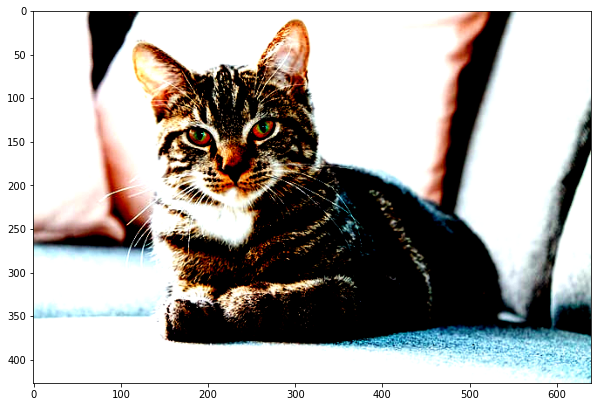

In [512]:
# Augment an image
transformed = transform(image=image)
transformed_image = transformed["image"]
show_img_grid(transformed_image.unsqueeze(0))

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.optim as optim
import numpy as np

In [40]:
L1 = False
L2 = False
weight_decay = 1e-5 if L2 else 0

optimizer = optim.SGD(
    net.parameters(), 
    lr=0.020, momentum=0.9, 
    weight_decay=weight_decay
)
lr_scheduler = ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, 
    patience=2, min_lr=0.001, verbose=True
)

In [46]:
train_loss_batch, train_acc_batch = train(
    net, device, 
    train_loader, 
    optimizer, 
    lr_scheduler,
    L1=L1
)
train_acc = np.mean(train_acc_batch)
train_loss = np.mean(train_loss_batch)

  0%|          | 0/938 [00:00<?, ?it/s]

In [49]:
test_loss, test_acc = test(
    net, device, 
    test_loader,
    lr_scheduler
)


Test set: Average loss: 0.0628, Accuracy: 9794/10000 (97.94%)

